In [1]:
import gemmi
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

In [2]:
def cif_to_smiles_with_coordinates(cif_file):
    # Read CIF file
    structure = gemmi.read_structure(cif_file)
    
    # Convert to RDKit mol object
    mol = Chem.MolFromPDBBlock(structure.make_minimal_pdb())
    
    # Generate SMILES
    smiles = Chem.MolToSmiles(mol)
    
    # Get 3D coordinates from the original structure
    coords = {}
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    coords[atom.name] = atom.pos.tolist()
    
    # Create a new mol from SMILES to get atom order
    mol_from_smiles = Chem.MolFromSmiles(smiles)
    
    # Add hydrogens to match the original molecule
    mol_from_smiles = Chem.AddHs(mol_from_smiles)
    
    # Get atom mapping between SMILES and original mol
    atom_mapping = mol.GetSubstructMatch(mol_from_smiles)
    
    # Collect coordinates in SMILES atom order
    ordered_coords = []
    for idx in atom_mapping:
        atom = mol.GetAtomWithIdx(idx)
        atom_name = atom.GetPDBResidueInfo().GetName().strip()
        ordered_coords.append(coords[atom_name])
    
    return smiles, ordered_coords

In [2]:
from converters import convert_cif_to_mol, convert_xyz_to_mol

In [11]:
mol = convert_cif_to_mol('1572856.cif')

print(Chem.MolToSmiles(mol))

[C][N][N].[H].[Ni].[Ni]


In [4]:
c = mol.GetConformer(0)

c.GetNumAtoms()

94

In [16]:
c.GetAtomPosition(0).y

7.6875

In [10]:
from converters import convert_xyz_to_mol

mol = convert_xyz_to_mol('dsgdb9nsd_000087.xyz')

# print SMILES
print(Chem.MolToSmiles(mol))

[H]C([H])([H])C1(C([H])([H])[H])OC1([H])[H]


In [6]:
c = mol.GetConformer(0)

[c.GetAtomPosition(i).x for i in range(c.GetNumAtoms())]

[-0.0397,
 -0.0302,
 -1.2461,
 0.7894,
 1.2255,
 0.8899,
 -0.8795,
 -0.1445,
 -2.1522,
 -1.1341,
 -1.3859,
 0.5071,
 1.3709]

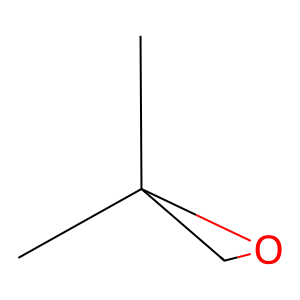

In [7]:
# canonicalize the molecule and draw it
# mol = convert_xyz_to_mol('dsgdb9nsd_000087.xyz')
mol = Chem.RemoveHs(mol)

Draw.MolToImage(mol)

In [2]:
import numpy as np
from rdkit import Chem

def validate_xyz_conversion(xyz_file: str, rdkit_mol: Chem.rdchem.Mol) -> bool:
    """
    Validate the conversion by comparing atomic coordinates and composition.
    
    Args:
        xyz_file (str): Path to the original XYZ file
        rdkit_mol (rdkit.Chem.rdchem.Mol): Converted RDKit molecule
        
    Returns:
        bool: True if validation passes, False otherwise
    """
    # Read original XYZ coordinates
    with open(xyz_file, 'r') as f:
        lines = f.readlines()
        
    n_atoms = int(lines[0])
    xyz_coords = []
    xyz_atoms = []

    gtSmiles = lines[-2].strip().replace(" ", "")
    # canonicalize the SMILES
    gtMol = Chem.MolFromSmiles(gtSmiles)
    gtMol = Chem.Mol(gtMol)
    gtMol = Chem.AddHs(gtMol)
    Chem.SanitizeMol(gtMol)

    gtSmiles = Chem.MolToSmiles(gtMol)

    smi = Chem.MolToSmiles(rdkit_mol)
    # assert gtSmiles == smi, f"SMILES mismatch: {gtSmiles} != {smi}"

    assert gtMol.GetNumAtoms() == rdkit_mol.GetNumAtoms(), f"Number of atoms mismatch: {gtMol.GetNumAtoms()} != {rdkit_mol.GetNumAtoms()}"
    
    for line in lines[2:n_atoms+2]:
        atom, x, y, z, _ = line.replace('*^', 'e').split()
        xyz_atoms.append(atom)
        xyz_coords.append([float(x), float(y), float(z)])
    
    xyz_coords = np.array(xyz_coords)
    
    # Get RDKit coordinates
    conf = rdkit_mol.GetConformer()
    rdkit_coords = conf.GetPositions()
    rdkit_atoms = [atom.GetSymbol() for atom in rdkit_mol.GetAtoms()]
    
    # Compare number of atoms
    if len(xyz_atoms) != len(rdkit_atoms):
        print("Number of atoms mismatch!")
        return False
    
    # Compare atomic composition
    assert xyz_atoms == rdkit_atoms
    
    # Compare coordinates (with small tolerance for numerical differences)
    coord_diff = np.abs(xyz_coords - rdkit_coords).max()
    if coord_diff > 1e-3:
        print("Coordinates mismatch!")
        return False
        
    return True

In [3]:
QM9_PATH = "/auto/home/davit/dsgdb9nsd.xyz/"
from tqdm import tqdm
import os
from converters import convert_xyz_to_mol

import traceback


def c():
    # List all files ending with .xyz
    xyz_files = [f for f in os.listdir(QM9_PATH) if f.endswith(".xyz") and "gdb" in f]
    pinv = 0
    inv = 0
    with_dot = 0
    for f in tqdm(xyz_files):
        try:
            mol = convert_xyz_to_mol(os.path.join(QM9_PATH, f))
        except ValueError as e:
            pass
        except Exception as e:
            pinv += 1
            traceback.print_exc()

            print("FAILED PATH: ", os.path.join(QM9_PATH, f))
            return

        assert mol is not None
        smi = Chem.MolToSmiles(mol)
        assert smi != ""
        with_dot += "." in smi

        inv += validate_xyz_conversion(os.path.join(QM9_PATH, f), mol)

    print(f"Can't parse: {pinv}")
    print(f"Invalid: {inv}")
    print(f"With dot: {with_dot}")


In [4]:
c()

  0%|          | 0/133885 [00:00<?, ?it/s]==============================
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is gdb 132881	3.17896	1.44284	0.99241	1.4572	67.71	-0.2062	-0.049	0.1572	1066.246	0.089499	-494.061446	-494.05391	-494.052966

AssertionError: 

In [17]:
mol = Chem.MolFromMolFile("./debug.mol", removeHs=False, sanitize=False)

gt_mol = Chem.MolFromSmiles("CN=C(N)N(C)C=O")
gt_mol = Chem.AddHs(gt_mol)
Chem.MolToSmiles(gt_mol)

print(Chem.MolToSmiles(mol))

gt_mol.GetProp("_smilesAtomOutputOrder")

[H]C(=O)N(C(NC([H])([H])[H])=N([H])[H])C([H])([H])[H]


'[16,6,7,4,2,1,0,8,9,10,3,11,12,5,13,14,15,]'

In [7]:
convert_xyz_to_mol("/auto/home/davit/dsgdb9nsd.xyz/dsgdb9nsd_008782.xyz")

[17:17:09] Explicit valence for atom # 3 N, 4, is greater than permitted


ValueError: Failed to convert /auto/home/davit/dsgdb9nsd.xyz/dsgdb9nsd_008782.xyz to mol.

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdForceFieldHelpers import UFFGetMoleculeForceField

from converters import convert_xyz_to_mol

def optimize_conformer(mol, conf_id):
    """Optimize the geometry of a specific conformer."""
    ff = UFFGetMoleculeForceField(mol, confId=conf_id)
    ff.Minimize()
    return ff.CalcEnergy()

def add_and_optimize_conformers(mol, N):
    """Generate N conformers, optimize them, and return the average energy."""
    energies = [0]
    energies[0] = UFFGetMoleculeForceField(mol, confId=0).CalcEnergy()
    
    AllChem.EmbedMultipleConfs(mol, numConfs=N, randomSeed=42)

    for conf_id in range(1, mol.GetNumConformers()):
        energy = optimize_conformer(mol, conf_id)
        energies.append(energy)
    
    # Compute the average energy of all N conformers (excluding the initial one)
    avg_energy_N_conformers = sum(energies[1:]) / N  # Exclude the initial conformer (index 0)
    
    # Return initial conformer energy and average energy of N conformers
    return energies[0], avg_energy_N_conformers


# mol = convert_xyz_to_mol('/auto/home/davit/3DMolGen/tests/fixtures/aspirin.xyz')
mol = convert_xyz_to_mol('/auto/home/davit/3DMolGen/tests/fixtures/dsgdb9nsd_000087.xyz')

N = 5  # Number of additional conformers to generate
initial_energy, avg_energy_N_conformers = add_and_optimize_conformers(mol, N)

print(f"Initial conformer energy: {initial_energy:.4f} kcal/mol")
print(f"Average energy of {N} conformers: {avg_energy_N_conformers:.4f} kcal/mol")


Initial conformer energy: 343.9519 kcal/mol
Average energy of 5 conformers: 271.8078 kcal/mol
